# Mini CNN Image Classifier + Topology (Persistent Homology) Detector (Synthetic Images, 3 Classes)

This notebook is a 3-class variant of `notebooks/05_cnn_image_topology_detector.ipynb`.

We will:
- generate a synthetic dataset with **3 classes**: **circle**, **square**, **triangle**
- train a small CNN (3-way classification)
- generate adversarial examples (FGSM/PGD) in pixel space
- compute topology (PH) features on local kNN neighborhoods in embedding space
- fit a `TopologyScoreDetector` and evaluate AUROC/AUPRC/FPR@95%TPR

In [1]:
# Imports + path setup + dependency checks
import os
import sys
import importlib
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Project root
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data import create_data_loaders
from src.models import train_model, evaluate_model, extract_features_batch, get_model_predictions
from src.detectors import train_graph_detector
from src.evaluation import evaluate_detector
from src.topology_features import TopologyConfig, local_persistence_features
from src.utils import ExperimentConfig, set_seed
from src.visualization import plot_roc_from_metrics, plot_confusion_matrix

In [2]:
SEED = 10

DEVICE = "cpu"
NUM_CLASSES = 3  # circle / square / triangle

# Dataset sizes
N_TRAIN = 2400
N_VAL = 600
N_TEST = 600

# Training
EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3

# Attack (inputs in [0,1])
ATTACK_TYPE = 'fgsm'  # 'fgsm' or 'pgd'
EPSILON = 0.05
PGD_STEPS = 10
PGD_STEP_SIZE = 0.007

# Topology detector settings
TOPO_K = 40
TOPO_MAXDIM = 1
TOPO_PREPROCESS = 'pca'
TOPO_PCA_DIM = 10
TOPO_MIN_PERSISTENCE = 1e-6

TOPO_PERCENTILE = 95.0
TOPO_COV_SHRINKAGE = 1e-3

# PH can be expensive; subsample scoring points
MAX_POINTS_FOR_SCORING = 300

print(f"Classes: {NUM_CLASSES} (circle/square/triangle)")
print(f"Attack: {ATTACK_TYPE}, eps={EPSILON}")

Classes: 3 (circle/square/triangle)
Attack: fgsm, eps=0.05


In [3]:
# Helpers
from typing import Tuple, Dict, List

from src.data import load_synthetic_shapes_3class


def plot_samples_grid(X: np.ndarray, y: np.ndarray, *, title: str, n_show: int = 12):
    n_show = int(min(n_show, len(X)))
    n_cols = 6
    n_rows = int(np.ceil(n_show / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.0 * n_cols, 2.0 * n_rows))
    axes = np.asarray(axes).reshape(n_rows, n_cols)

    for i in range(n_rows * n_cols):
        r, c = divmod(i, n_cols)
        ax = axes[r, c]
        if i < n_show:
            img = X[i].transpose(1, 2, 0)
            ax.imshow(np.clip(img, 0, 1))
            ax.set_title(f"y={int(y[i])}")
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


from src.models import MiniCNN
from src.adv_attacks import generate_adversarial_examples_images


def compute_success_mask(model: nn.Module, X_clean: np.ndarray, X_adv: np.ndarray, y: np.ndarray, device: str):
    pred_clean = get_model_predictions(model, X_clean, device=device)
    pred_adv = get_model_predictions(model, X_adv, device=device)
    clean_correct = (pred_clean == y)
    success = clean_correct & (pred_adv != y)
    return pred_clean, pred_adv, clean_correct, success


def show_successful_attacks(
    X_clean: np.ndarray,
    X_adv: np.ndarray,
    y_true: np.ndarray,
    pred_clean: np.ndarray,
    pred_adv: np.ndarray,
    success_mask: np.ndarray,
    *,
    epsilon: float,
    n_show: int = 6,
    seed: int = 0,
):
    idx = np.where(success_mask)[0]
    if len(idx) == 0:
        print("No successful attacks to show.")
        return

    rng = np.random.default_rng(seed)
    chosen = rng.choice(idx, size=min(n_show, len(idx)), replace=False)

    fig, axes = plt.subplots(len(chosen), 2, figsize=(7, 3 * len(chosen)))
    if len(chosen) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, i in enumerate(chosen):
        clean = np.clip(X_clean[i].transpose(1, 2, 0), 0, 1)
        adv = np.clip(X_adv[i].transpose(1, 2, 0), 0, 1)
        axes[r, 0].imshow(clean); axes[r, 0].axis('off'); axes[r, 0].set_title(f"clean y={int(y_true[i])}, pred={int(pred_clean[i])}")
        axes[r, 1].imshow(adv); axes[r, 1].axis('off'); axes[r, 1].set_title(f"adv pred={int(pred_adv[i])} (eps={epsilon})")

    plt.tight_layout(); plt.show()


def compute_topology_feature_scores(
    X_points: np.ndarray,
    *,
    model: nn.Module,
    Z_train: np.ndarray,
    graph_cfg,
    device: str,
    layer: str = 'penultimate',
) -> Dict[str, np.ndarray]:
    from sklearn.neighbors import NearestNeighbors

    if graph_cfg.space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer=layer, device=device)
    else:
        Z_points = X_points

    topo_cfg = TopologyConfig(
        neighborhood_k=int(getattr(graph_cfg, 'topo_k', 50)),
        maxdim=int(getattr(graph_cfg, 'topo_maxdim', 1)),
        metric=str(getattr(graph_cfg, 'topo_metric', 'euclidean')),
        thresh=getattr(graph_cfg, 'topo_thresh', None),
        min_persistence=float(getattr(graph_cfg, 'topo_min_persistence', 1e-6)),
        preprocess=str(getattr(graph_cfg, 'topo_preprocess', 'none')),
        pca_dim=int(getattr(graph_cfg, 'topo_pca_dim', 10)),
    )

    nbrs = NearestNeighbors(n_neighbors=min(topo_cfg.neighborhood_k, len(Z_train)), metric=topo_cfg.metric).fit(Z_train)

    feat_dicts = []
    for i in range(len(Z_points)):
        _, idx = nbrs.kneighbors(Z_points[i].reshape(1, -1))
        neighborhood = Z_train[idx[0]]
        cloud = np.vstack([Z_points[i].reshape(1, -1), neighborhood])
        feat_dicts.append(local_persistence_features(cloud, topo_cfg))

    all_keys = sorted({k for d in feat_dicts for k in d.keys()})
    return {k: np.array([d.get(k, 0.0) for d in feat_dicts], dtype=float) for k in all_keys}


def concat_scores(scores_a: Dict[str, np.ndarray], scores_b: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    keys = sorted(set(scores_a.keys()) | set(scores_b.keys()))
    out: Dict[str, np.ndarray] = {}
    for k in keys:
        a = scores_a.get(k)
        b = scores_b.get(k)
        if a is None:
            a = np.zeros(len(next(iter(scores_a.values()))), dtype=float)
        if b is None:
            b = np.zeros(len(next(iter(scores_b.values()))), dtype=float)
        out[k] = np.concatenate([a, b])
    return out


def subsample_masked(X: np.ndarray, y: np.ndarray, mask: np.ndarray, n_max: int, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return X[:0], y[:0]
    if len(idx) > n_max:
        idx = rng.choice(idx, size=n_max, replace=False)
    return X[idx], y[idx]


In [4]:
# Load dataset (3 classes)
DATASET_NAME = "SyntheticShapes3 (circle/square/triangle)"
X_train, y_train, X_val, y_val, X_test, y_test = load_synthetic_shapes_3class(
    n_train=N_TRAIN, n_val=N_VAL, n_test=N_TEST, seed=SEED, image_size=32
)

print(f"Dataset: {DATASET_NAME}")
print(f"X_train: {X_train.shape} | class counts: {np.bincount(y_train, minlength=NUM_CLASSES).tolist()}")
print(f"X_val:   {X_val.shape} | class counts: {np.bincount(y_val, minlength=NUM_CLASSES).tolist()}")
print(f"X_test:  {X_test.shape} | class counts: {np.bincount(y_test, minlength=NUM_CLASSES).tolist()}")

Dataset: SyntheticShapes3 (circle/square/triangle)
X_train: (2400, 3, 32, 32) | class counts: [800, 800, 800]
X_val:   (600, 3, 32, 32) | class counts: [200, 200, 200]
X_test:  (600, 3, 32, 32) | class counts: [200, 200, 200]


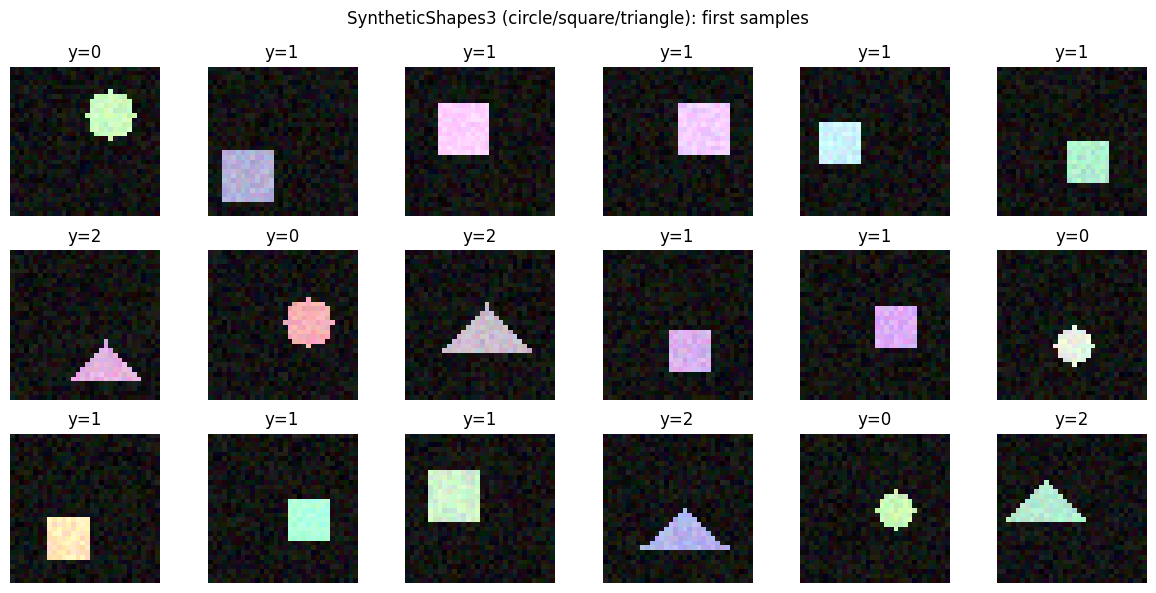

In [5]:
# Visual sanity-check
plot_samples_grid(X_train, y_train, title=f"{DATASET_NAME}: first samples", n_show=18)

In [6]:
# Model + experiment config
config = ExperimentConfig(seed=SEED, device=DEVICE)

config.model.epochs = EPOCHS
config.model.batch_size = BATCH_SIZE
config.model.learning_rate = LR

config.attack.attack_type = ATTACK_TYPE
config.attack.epsilon = EPSILON
config.attack.num_steps = PGD_STEPS
config.attack.step_size = PGD_STEP_SIZE
config.attack.random_start = True

config.graph.space = 'feature'
config.graph.use_topology = True
config.graph.use_tangent = False
config.graph.topo_k = TOPO_K
config.graph.topo_maxdim = TOPO_MAXDIM
config.graph.topo_preprocess = TOPO_PREPROCESS
config.graph.topo_pca_dim = TOPO_PCA_DIM
config.graph.topo_min_persistence = TOPO_MIN_PERSISTENCE

config.detector.detector_type = 'topology_score'
config.detector.topo_percentile = TOPO_PERCENTILE
config.detector.topo_cov_shrinkage = TOPO_COV_SHRINKAGE

model = MiniCNN(num_classes=NUM_CLASSES, feat_dim=128)
print(model)

MiniCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)


In [7]:
# Train
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=config.model.batch_size,
)

history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=True)

test_loss, test_acc = evaluate_model(model, test_loader, device=config.device)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

Epoch [10/10] Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.0004, Val Acc: 100.00%
Test loss: 0.0003 | Test accuracy: 100.00%


In [8]:
# Adversarial examples + success masks
X_adv_val = generate_adversarial_examples_images(
    model, X_val, y_val,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)
X_adv_test = generate_adversarial_examples_images(
    model, X_test, y_test,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)

EVAL_ONLY_SUCCESSFUL_ATTACKS = True
FILTER_CLEAN_TO_CORRECT = True

pred_val_clean, pred_val_adv, val_clean_correct, val_success = compute_success_mask(model, X_val, X_adv_val, y_val, device=DEVICE)
pred_test_clean, pred_test_adv, test_clean_correct, test_success = compute_success_mask(model, X_test, X_adv_test, y_test, device=DEVICE)

print(f"Val successful attacks:  {val_success.sum()}/{len(val_success)} = {val_success.mean():.3f}")
print(f"Test successful attacks: {test_success.sum()}/{len(test_success)} = {test_success.mean():.3f}")

Val successful attacks:  364/600 = 0.607
Test successful attacks: 368/600 = 0.613


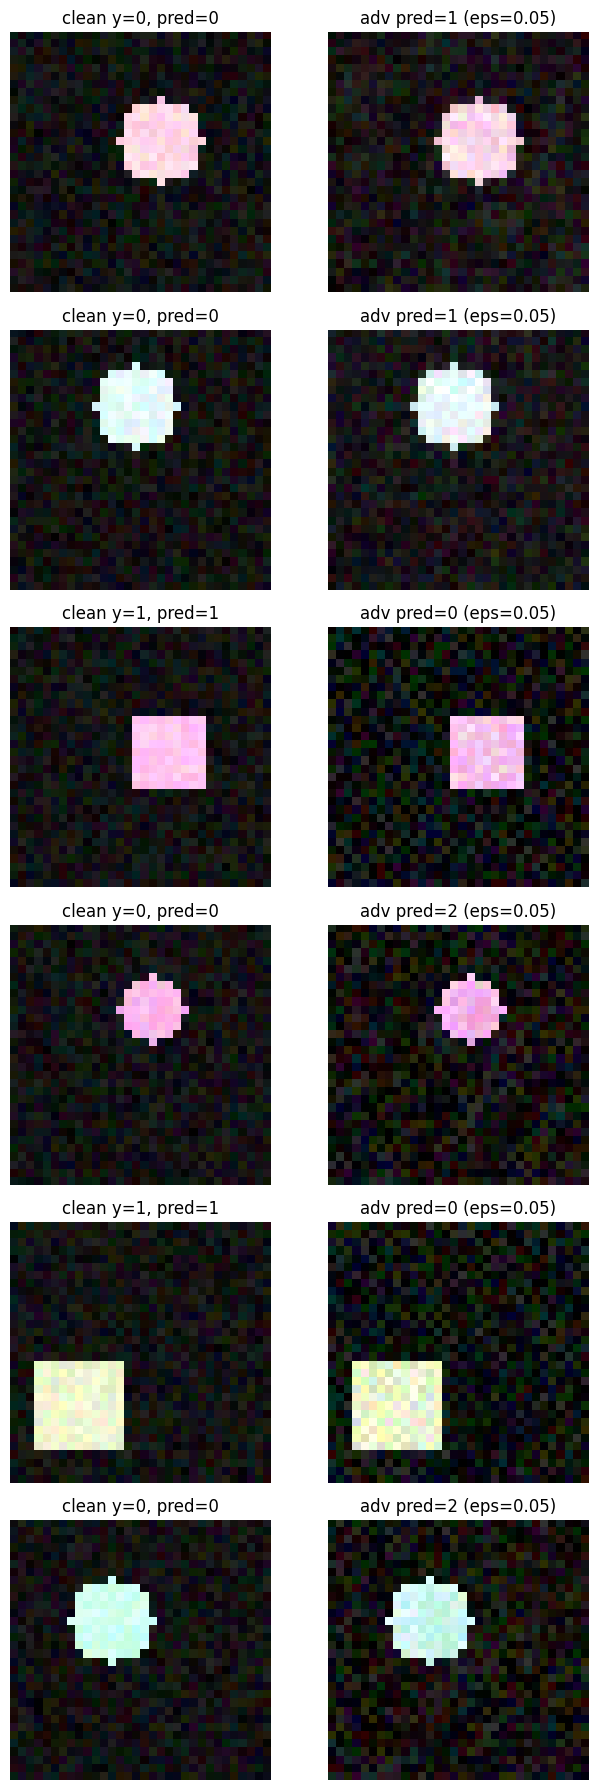

In [9]:
# Visualize a few successful attacks
show_successful_attacks(
    X_test, X_adv_test, y_test,
    pred_test_clean, pred_test_adv,
    test_success,
    epsilon=EPSILON,
    n_show=6,
    seed=SEED,
)

In [10]:
# Reference embedding set from TRAIN
Z_train = extract_features_batch(model, X_train, layer='penultimate', device=DEVICE)
print(f"Z_train: {Z_train.shape}")

Z_train: (2400, 128)


Detector performance (topology_mahalanobis):
  AUROC:     0.9962
  AUPRC:     0.9970
  FPR@95TPR: 0.0033


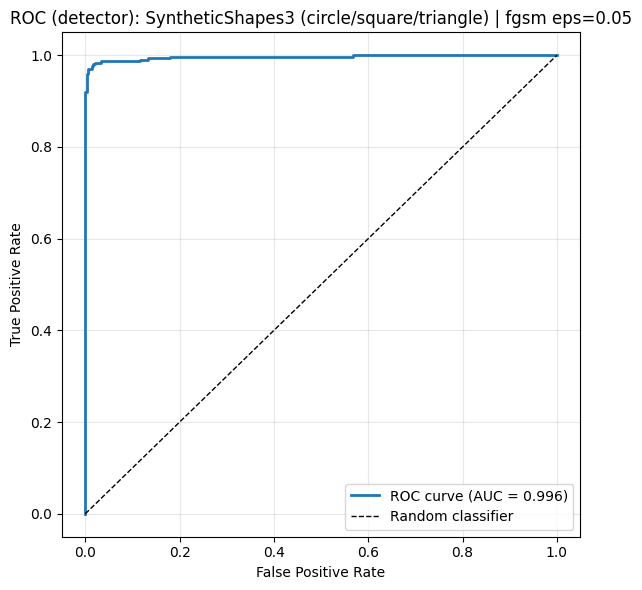

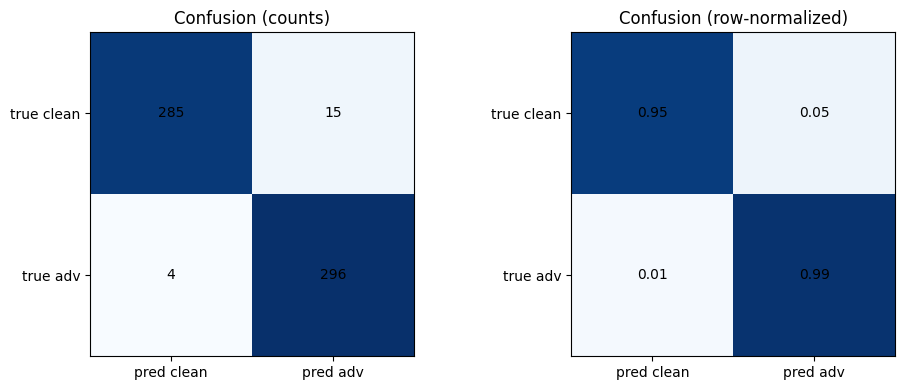

{'fig': <Figure size 1000x400 with 2 Axes>,
 'axes': array([<Axes: title={'center': 'Confusion (counts)'}>,
        <Axes: title={'center': 'Confusion (row-normalized)'}>],
       dtype=object),
 'tn': 285,
 'fp': 15,
 'fn': 4,
 'tp': 296,
 'cm': array([[285.,  15.],
        [  4., 296.]]),
 'cm_norm': array([[0.95      , 0.05      ],
        [0.01333333, 0.98666667]])}

In [11]:
# Topology-score detector
clean_mask_val = val_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_val), dtype=bool)
clean_mask_test = test_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_test), dtype=bool)
adv_mask_val = val_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_val), dtype=bool)
adv_mask_test = test_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_test), dtype=bool)

seed0 = int(getattr(config, 'seed', 42))
X_val_clean_used, _ = subsample_masked(X_val, y_val, clean_mask_val, MAX_POINTS_FOR_SCORING, seed=seed0)
X_test_clean_used, _ = subsample_masked(X_test, y_test, clean_mask_test, MAX_POINTS_FOR_SCORING, seed=seed0 + 1)
X_val_adv_used, _ = subsample_masked(X_adv_val, y_val, adv_mask_val, MAX_POINTS_FOR_SCORING, seed=seed0 + 2)
X_test_adv_used, _ = subsample_masked(X_adv_test, y_test, adv_mask_test, MAX_POINTS_FOR_SCORING, seed=seed0 + 3)

scores_val_clean = compute_topology_feature_scores(X_val_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_val_adv = compute_topology_feature_scores(X_val_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

scores_test_clean = compute_topology_feature_scores(X_test_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_test_adv = compute_topology_feature_scores(X_test_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
any_key = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key]), dtype=int),
    np.ones(len(scores_val_adv[any_key]), dtype=int),
])

detector = train_graph_detector(scores_val_all, labels_val, config.detector)

scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
labels_test = np.concatenate([
    np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
    np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
])

score_fn = getattr(detector, 'score', None)
assert callable(score_fn)
raw_scores_test = np.asarray(score_fn(scores_test_all), dtype=float)
metrics = evaluate_detector(labels_test, raw_scores_test)

print("Detector performance (topology_mahalanobis):")
print(f"  AUROC:     {metrics['roc_auc']:.4f}")
print(f"  AUPRC:     {metrics['pr_auc']:.4f}")
print(f"  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")

# ROC curve (shared utility)
plot_roc_from_metrics(
    metrics,
    title=f"ROC (detector): {DATASET_NAME} | {ATTACK_TYPE} eps={EPSILON}",
)

# Confusion matrix at the detector's threshold (shared utility)
thr = float(getattr(detector, 'threshold', 0.5))
plot_confusion_matrix(labels_test, y_scores=raw_scores_test, threshold=thr, labels=("clean", "adv"))
